## [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html)

## [Cholesky factors of covariance matrices](https://mc-stan.org/docs/reference-manual/cholesky-factors-of-covariance-matrices-1.html)

[Cholesky factors of covariance and correlation matrices in Stan](https://yingqijing.medium.com/cholesky-factors-of-covariance-and-correlation-matrices-in-stan-37a302d11690)

A Cholesky factor of a covariance matrix requires $N + (N/2) + (M−N)N$ unconstrained parameters.

$$y^T=(y_1,y_2, ..., y_p)$$
$$y=\Lambda \theta + \epsilon$$

$$\Lambda=
\begin{bmatrix}
\lambda_{1,1} & \lambda_{1,2} & \dots & \lambda_{1,D}\\
\lambda_{2,1} & \lambda_{2,2} & \dots & \lambda_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\lambda_{p,1} & \lambda_{p,2} & \dots & \lambda_{p,D}\\
\end{bmatrix}$$

$$\Phi_D = 
\begin{bmatrix}
1 & \varphi_{1,2} & \dots & \varphi_{1,D}\\
\varphi_{2,1} & 1 & \dots & \varphi_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\varphi_{D,1} & \dots &\varphi_{D,D-1} & 1\\
\end{bmatrix}$$

$$\Psi_P = 
\begin{bmatrix}
\psi_1 & 0 & \dots & 0\\
0 & \psi_2 & \dots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & \dots &0 & \psi_P\\
\end{bmatrix}$$

$$y\sim Normaal_P(0, \Lambda\Phi\Lambda^T+\Psi)$$

$$p(\Theta,\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N p(y_i|\theta_i,\Lambda)\right] \left[ \prod _{i=1}^{N} p(\theta_i|\Phi) \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

N D-dimensional latent vectors $\Theta=(\theta_1. \theta_2, \dots, theta_i, \dots, \theta_N)$
$$p(\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N \int_{R_\theta} p(y_i|\theta_i,\Lambda) p(\theta_i|\Phi) d\theta \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

$y_i$ is a P-dimensional vector of responses for respondent i

### orthogonal rotation matrix T, where $T^TT=I$ and $\lambda T^TT\theta=\Lambda\theta$

### Simulating Data

In [1]:
library(MASS)

In [2]:
D <- 3
P <- 10
N <- 300

In [3]:
mu_theta = rep(0, D)
mu_epsilon = rep(0, P)

In [4]:
Phi <- diag(rep(1,D))
Psi <- diag(c(0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27))

In [5]:
l1 <- c(0.99, 0.00, 0.25, 0.00, 0.80, 0.00, 0.50, 0.00, 0.00, 0.00)
l2 <- c(0.00, 0.90, 0.25, 0.40, 0.00, 0.50, 0.00, 0.00, -0.30, -0.30)
l3<-  c(0.00, 0.00, 0.85, 0.80, 0.00, 0.75, 0.75, 0.00, 0.80, 0.80)
L = cbind(l1,l2,l3)

In [6]:
Theta <- mvrnorm(N, mu_theta, Phi)

In [7]:
Epsilon <- mvrnorm(N, mu_epsilon, Psi)

In [8]:
Y <- Theta %*% t(L) + Epsilon

In [9]:
dim(Y)

[1] 300  10

In [10]:
dl_fa <- list(
    N = N,
    P = P,
    D = D,
    Y = Y
)

In [11]:
saveRDS(dl_fa, file = 'factor_data_list.rds')

### Visualization

In [12]:
library(rbokeh)

In [13]:
df <- data.frame(Y)

In [14]:
names(df)[1:P]

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10"

In [15]:
tools <- c("pan", "wheel_zoom", "resize", "reset")

In [16]:
nms <- expand.grid(names(df)[1:P], rev(names(df)[1:P]), stringsAsFactors = FALSE)

In [17]:
nms$Var2[1]

[1] "X10"

In [18]:
nms$yaxis <- rep(c(TRUE, rep(FALSE, P-1)), P)
nms$xaxis <- c(rep(FALSE, (P-1)*P), rep(TRUE, P))

In [19]:
nms$h <- nms$w <- 75
nms$h[nms$xaxis] <- nms$w[nms$yaxis] <- 90

In [20]:
library(ggplot2)
library(gridExtra)

In [21]:
plot_uni_scatter <- function(df, nms, i){
    return( ggplot(data = df, aes(x = get(nms$Var1[i]), y = get(nms$Var2[i]))) + geom_point(color='blue') +
    xlab(nms$Var1[i]) + ylab(nms$Var2[i]) + theme(axis.text = element_text(size=2), axis.title = element_text(size=3)) )
}

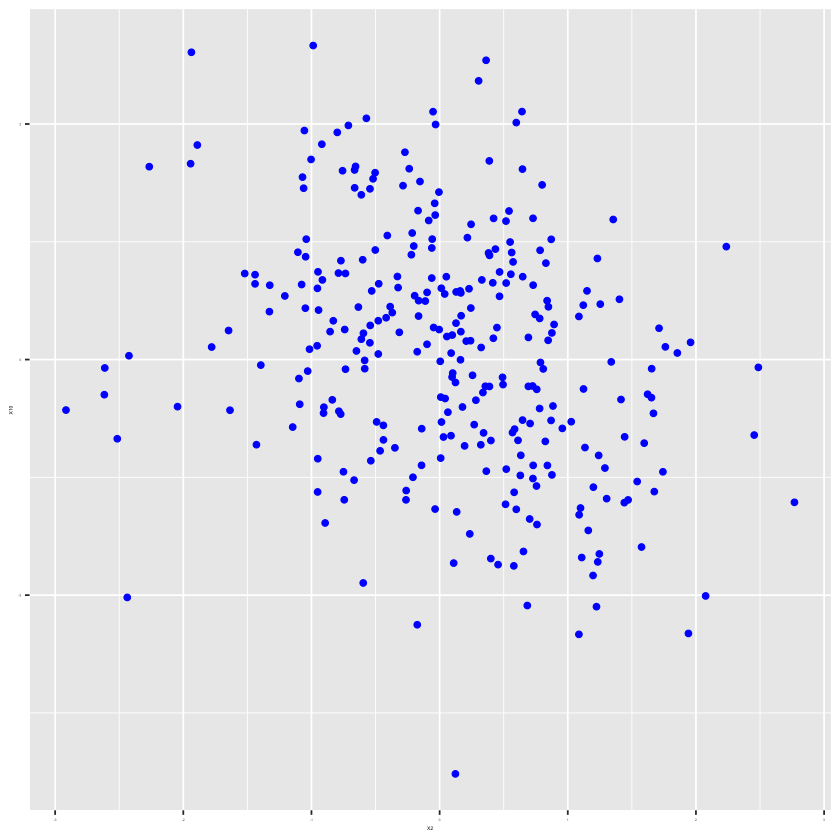

In [22]:
plot_uni_scatter(df, nms, 2)

In [23]:
plot_list <- vector('list', P^2)

In [24]:
for (i in seq_along(plot_list)){
    #message(i)
    p <-ggplotGrob(plot_uni_scatter(df, nms, i))
    plot_list[[i]] <- p
}

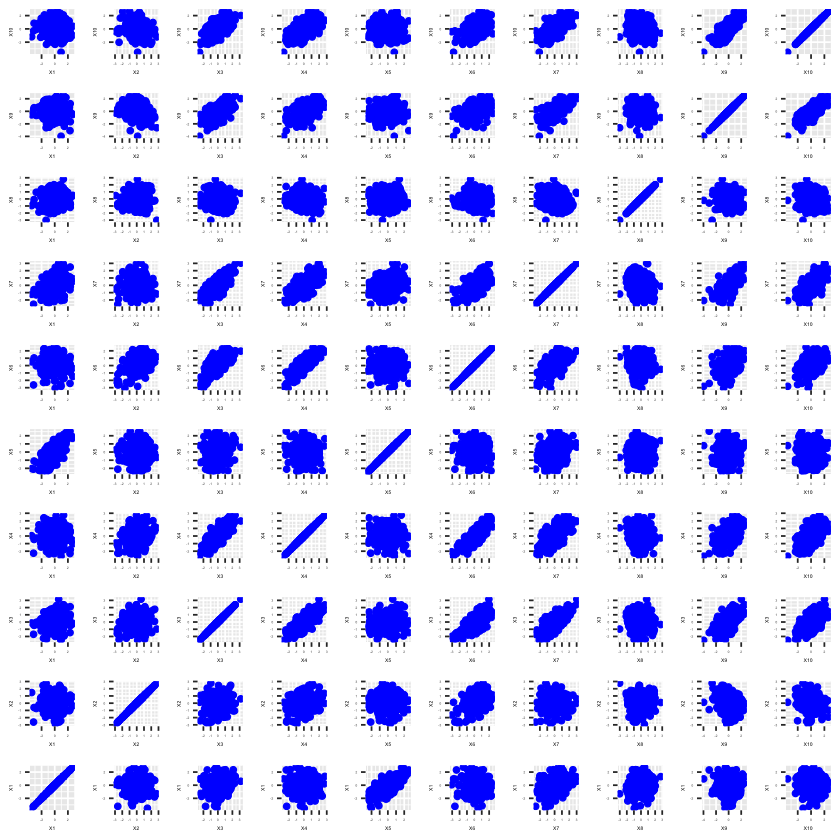

In [25]:
grid.arrange(grobs = plot_list, ncol = 10)